## Step 1: Import Required Libraries
We first import the necessary Python libraries for data handling, visualization, and word clouds.


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sqlalchemy import create_engine
import os
from urllib.parse import quote_plus

# Optional: Improve plot aesthetics
sns.set(style="whitegrid")


## Step 2: Load the Cleaned and Processed Data
We load the preprocessed reviews CSV file or connect to PostgreSQL to get the cleaned review data.


In [73]:
df = pd.read_csv('../data/clean/reviews_sentiment_themes_topic.csv')
df['date'] = pd.to_datetime(df['date'])
df.head()


,review,rating,date,bank,source,review_clean,vader_compound,sentiment_vader,sent_label,sent_score,text,theme_primary
0,very good,5,2025-11-25,BOA,google_play,very good,0.4927,positive,positive,0.999852,very good,App Functionality
1,most of the time is not working properly,1,2025-11-25,BOA,google_play,most of the time is not working properly,0.0000,neutral,negative,0.999764,most of the time is not working properly,Features & Update Requests
2,good service,5,2025-11-25,BOA,google_play,good service,0.4404,positive,positive,0.999850,good service,App Functionality
3,not use for me,3,2025-11-23,BOA,google_play,not use for me,0.0000,neutral,negative,0.995374,not use for me,Usability & App Comparison
4,It keeps notifying me to disable developer opt...,1,2025-11-22,BOA,google_play,it keeps notifying me to disable developer opt...,-0.4019,negative,negative,0.996833,it keeps notifying me to disable developer opt...,App Functionality


## Step 3: Identify Drivers (Positive Feedback) and Pain Points (Negative Feedback)
We filter the data by sentiment to identify the main drivers and pain points for each bank.


In [74]:
positive_reviews = df[df['sent_label'] == 'positive']
negative_reviews = df[df['sent_label'] == 'negative']

# Top themes per bank
for bank in df['bank'].unique():
    print(f"\nBank: {bank}")
    top_positive = positive_reviews[positive_reviews['bank']==bank]['theme_primary'].value_counts().head(5)
    print("Drivers (top positive themes):")
    print(top_positive)
    
    top_negative = negative_reviews[negative_reviews['bank']==bank]['theme_primary'].value_counts().head(5)
    print("Pain Points (top negative themes):")
    print(top_negative)



Bank: BOA
Drivers (top positive themes):
theme_primary
App Functionality             61
Performance                   50
Features & Update Requests    49
Core Service satisfaction     46
Usability & App Comparison    26
Name: count, dtype: int64
Pain Points (top negative themes):
theme_primary
Features & Update Requests    180
App Functionality              82
Usability & App Comparison     70
Core Service satisfaction      64
Performance                    61
Name: count, dtype: int64

Bank: CBE
Drivers (top positive themes):
theme_primary
Banking Efficiency & Speed     77
Transaction                    68
Accessibility & Ease of Use    62
Service Charges                60
Innovation & Integration       55
Name: count, dtype: int64
Pain Points (top negative themes):
theme_primary
Banking Efficiency & Speed     68
Transaction                    67
Accessibility & Ease of Use    54
Service Charges                42
Innovation & Integration       38
Name: count, dtype: int64

Bank: Dash

## Step 4: Compare Banks
Compare banks using average sentiment scores and rating distributions.


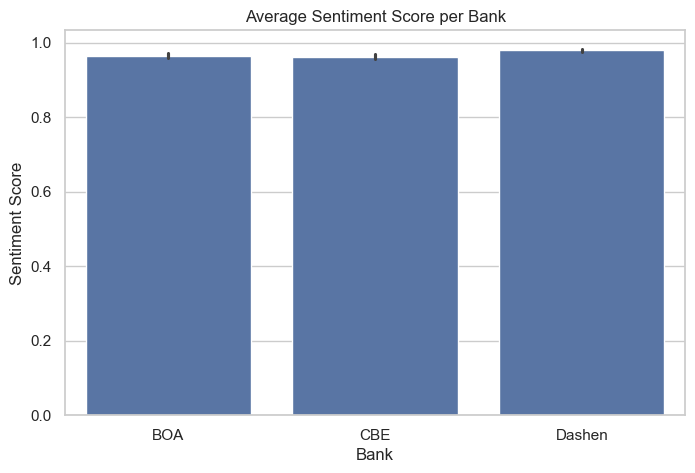

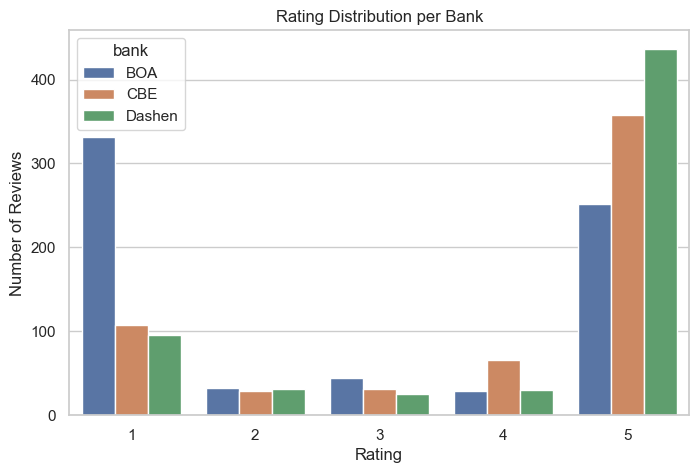

In [75]:
plt.figure(figsize=(8,5))
sns.barplot(x='bank', y='sent_score', data=df)
plt.title("Average Sentiment Score per Bank")
plt.ylabel("Sentiment Score")
plt.xlabel("Bank")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='rating', hue='bank', data=df)
plt.title("Rating Distribution per Bank")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()


## Step 5: Visualize Top Keywords and Themes
Generate word clouds and bar charts of most frequent keywords/themes per bank.


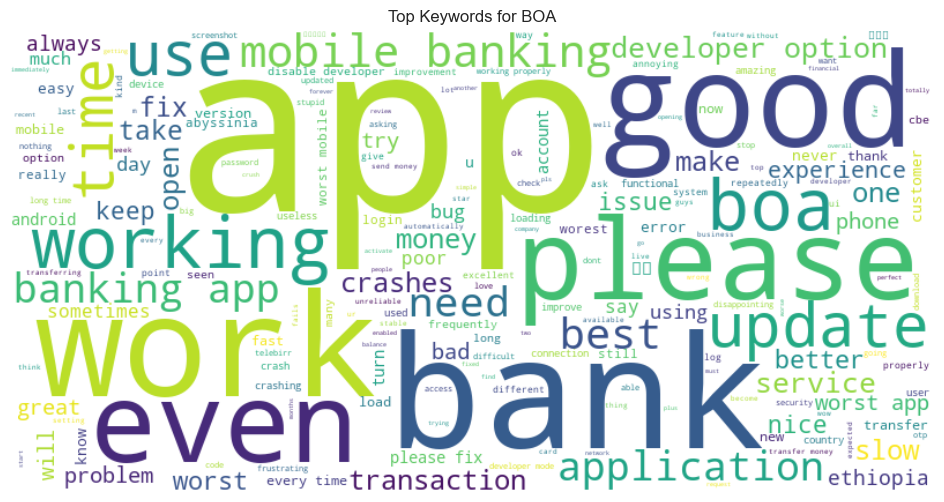

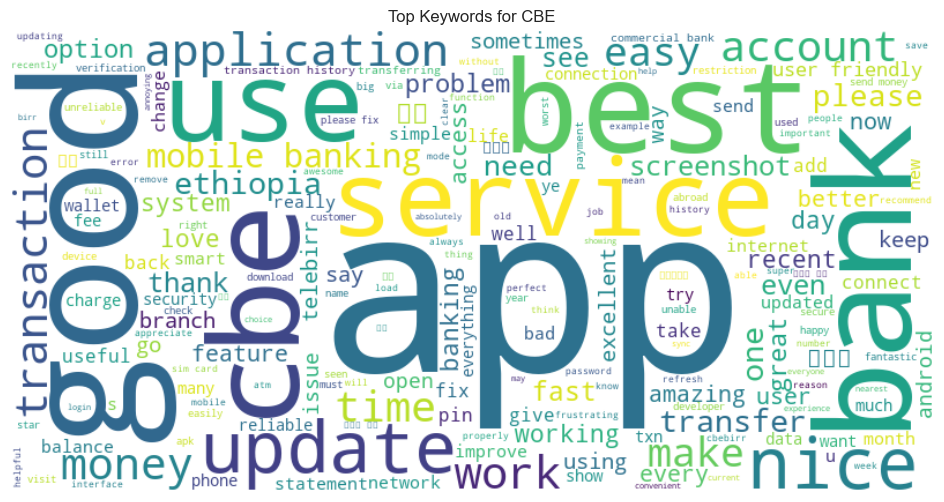

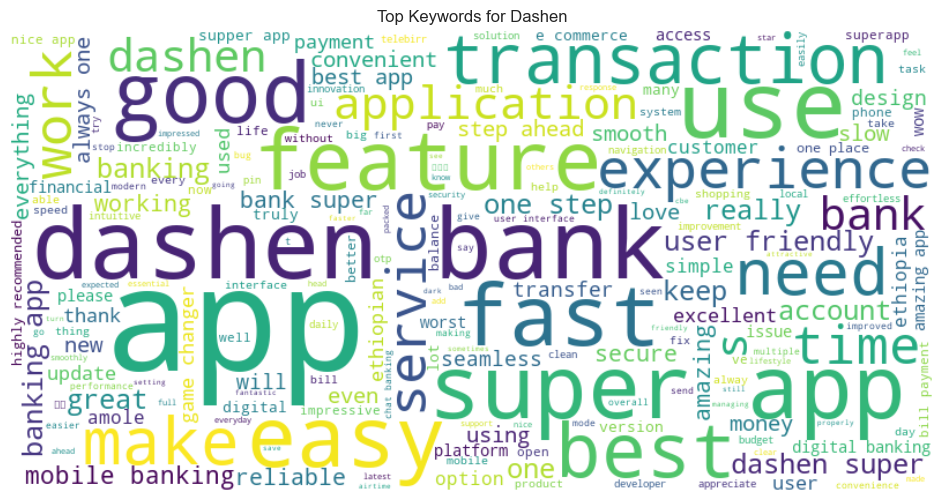

In [76]:
for bank in df['bank'].unique():
    text = " ".join(df[df['bank']==bank]['review_clean'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top Keywords for {bank}")
    plt.show()


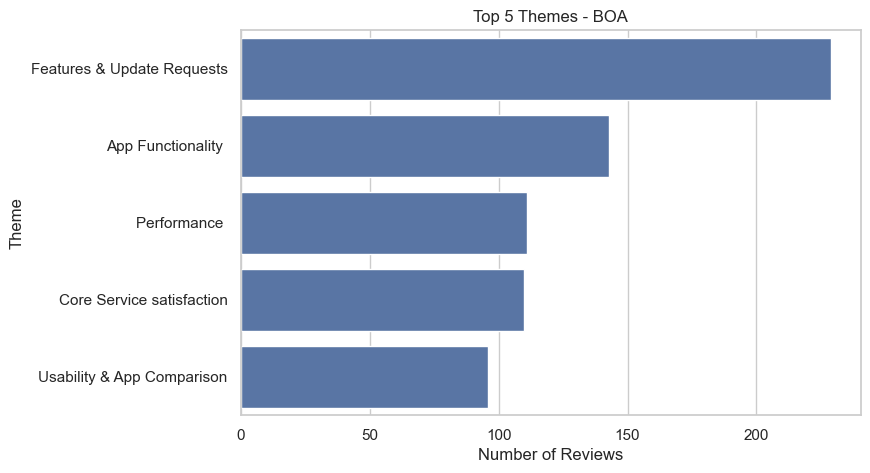

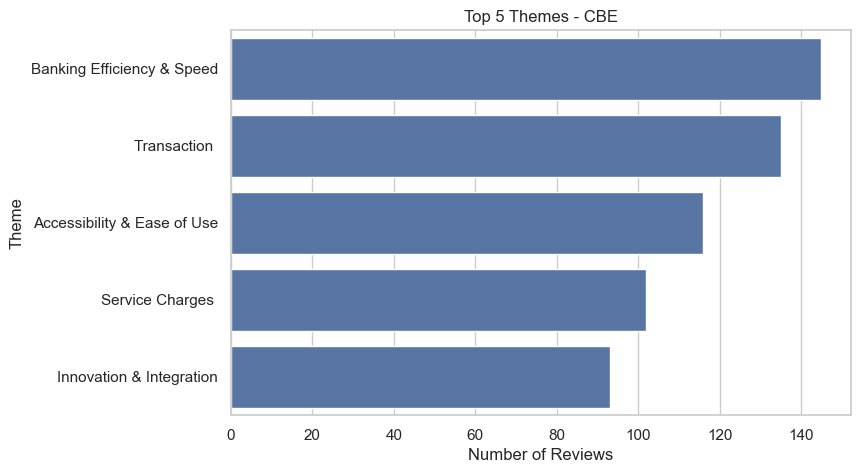

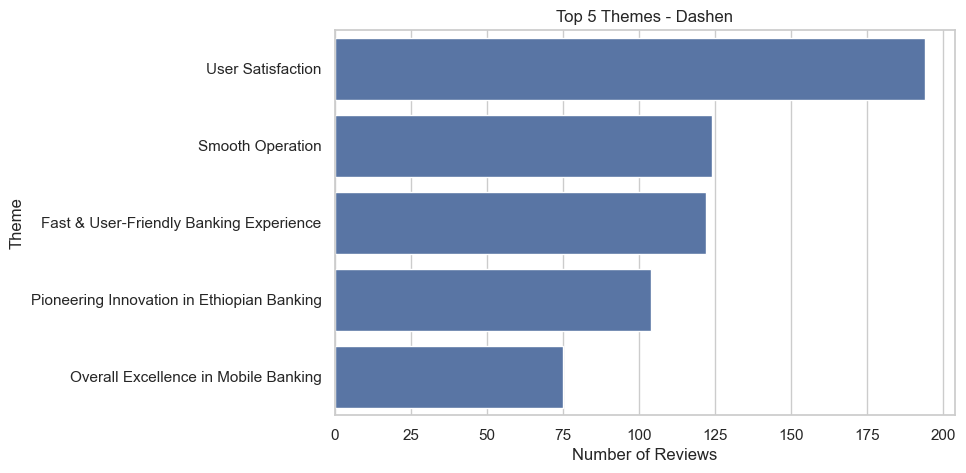

In [77]:
for bank in df['bank'].unique():
    theme_counts = df[df['bank']==bank]['theme_primary'].value_counts().head(5)
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=theme_counts.values, y=theme_counts.index)
    plt.title(f"Top 5 Themes - {bank}")
    plt.xlabel("Number of Reviews")
    plt.ylabel("Theme")
    plt.show()


## Step 6: Insights and Recommendations
Identify 2+ drivers and pain points per bank. Support recommendations with visualizations.


In [78]:
# df has columns: bank, theme_primary, sent_label
threshold = 5  # minimum mentions per theme
ratio = 0.6    # minimum ratio to consider driver/pain point

insights = {}
banks = df['bank'].unique()

for bank in banks:
    bank_df = df[df['bank'] == bank]
    themes = bank_df['theme_primary'].unique()
    drivers = []
    pain_points = []
    
    theme_ratios = {}
    
    for theme in themes:
        theme_reviews = bank_df[bank_df['theme_primary'] == theme]
        total = len(theme_reviews)
        if total < threshold:
            continue  # skip themes with too few mentions
        
        pos_ratio = (theme_reviews['sent_label'] == 'positive').sum() / total
        neg_ratio = (theme_reviews['sent_label'] == 'negative').sum() / total
        
        theme_ratios[theme] = {'pos': pos_ratio, 'neg': neg_ratio}
        
        if pos_ratio >= ratio:
            drivers.append(theme)
        elif neg_ratio >= ratio:
            pain_points.append(theme)
    
    # Ensure at least one driver
    if len(drivers) == 0 and theme_ratios:
        # Pick theme with highest positive ratio
        best_driver = max(theme_ratios.items(), key=lambda x: x[1]['pos'])[0]
        drivers.append(best_driver)
    
    # Ensure at least one pain point
    if len(pain_points) == 0 and theme_ratios:
        # Pick theme with highest negative ratio
        worst_pain = max(theme_ratios.items(), key=lambda x: x[1]['neg'])[0]
        pain_points.append(worst_pain)
    
    insights[bank] = {'drivers': drivers, 'pain_points': pain_points}

print(insights)


{'BOA': {'drivers': ['Performance '], 'pain_points': ['Features & Update Requests', 'Usability & App Comparison']}, 'CBE': {'drivers': ['Innovation & Integration'], 'pain_points': ['Transaction ']}, 'Dashen': {'drivers': ['User Satisfaction', 'Fast & User-Friendly Banking Experience', 'Pioneering Innovation in Ethiopian Banking'], 'pain_points': ['Smooth Operation']}}


## Step 7: Save Insights Summary
Save the drivers and pain points to CSV for reporting.


In [79]:
import matplotlib.pyplot as plt
import os

# --- 1. Save insights to CSV ---
insights_df = pd.DataFrame([
    {
        'bank': bank,
        'drivers': ", ".join(vals['drivers']),
        'pain_points': ", ".join(vals['pain_points'])
    }
    for bank, vals in insights.items()
])


insights_df.to_csv('../reports/insights_summary.csv', index=False)

print("Saved insights to reports/insights_summary.csv")


Saved insights to reports/insights_summary.csv


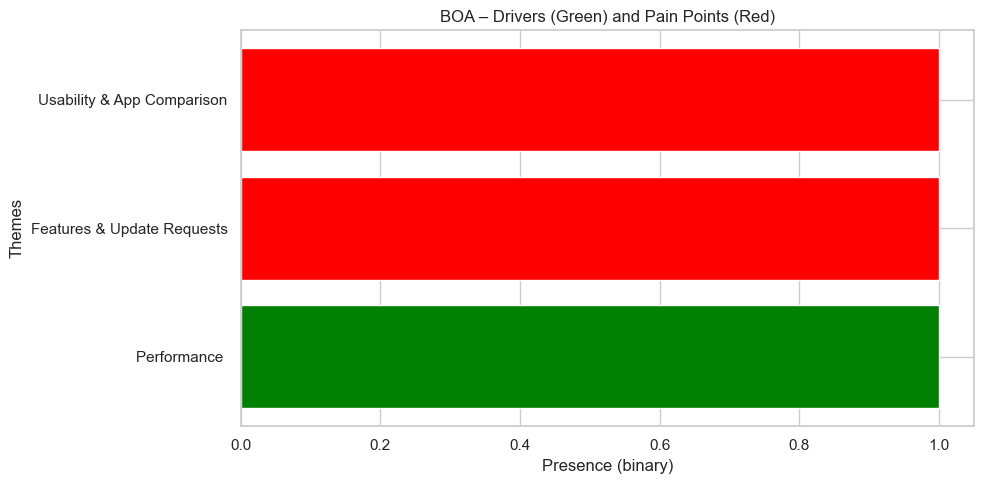

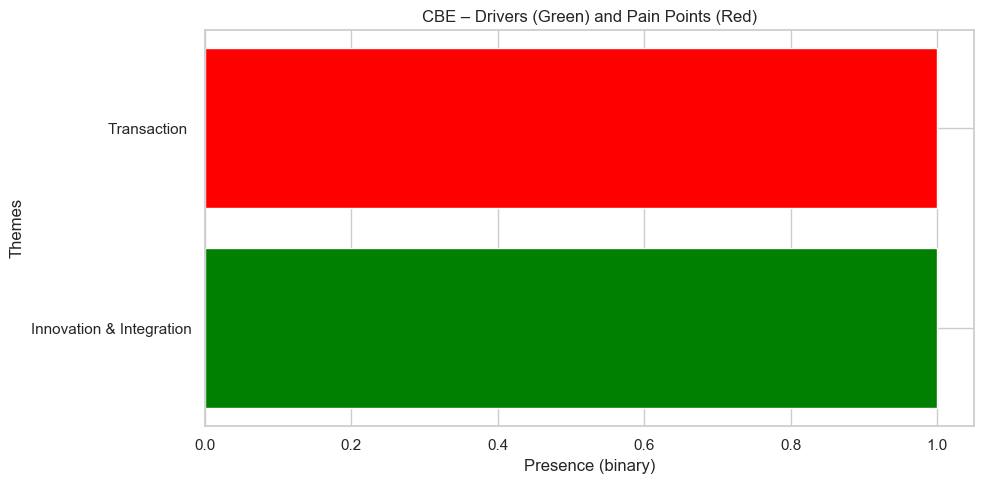

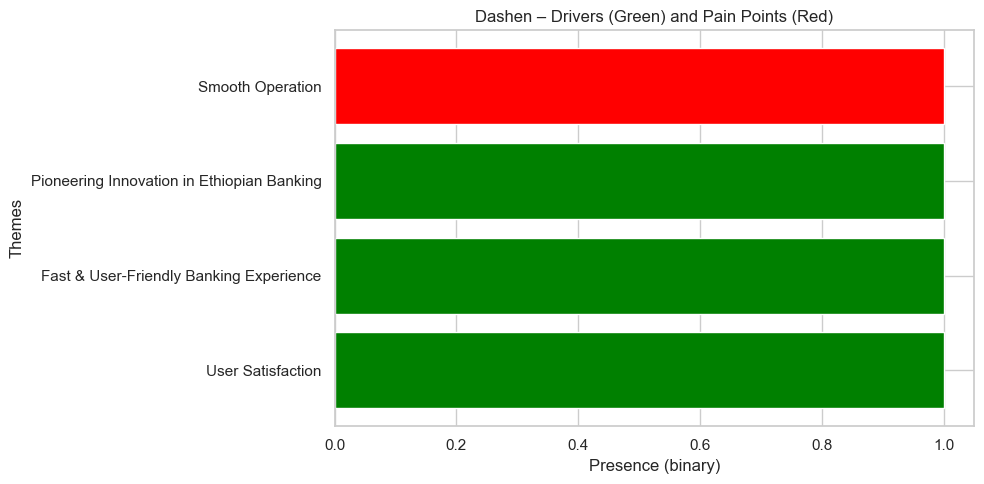

In [80]:
# --- 2. Visualize drivers and pain points per bank ---

for bank, vals in insights.items():
    drivers = vals['drivers']
    pains = vals['pain_points']
    
    # Nothing to visualize
    if len(drivers) == 0 and len(pains) == 0:
        continue
    
    labels = drivers + pains
    colors = ['green'] * len(drivers) + ['red'] * len(pains)
    counts = [1] * len(labels)   # Just to visualize presence
    
    plt.figure(figsize=(10, 5))
    plt.barh(labels, counts, color=colors)
    
    plt.title(f"{bank} – Drivers (Green) and Pain Points (Red)")
    plt.xlabel("Presence (binary)")
    plt.ylabel("Themes")
    
    plt.tight_layout()
    plt.show()


# ✅ Practical App Improvement Recommendations (Updated)

## 1️⃣ BOA

**Drivers:** Performance  
**Pain Points:** Features & Update Requests, Usability & App Comparison  

### 🔧 App Improvement Recommendations (Based on Your Data)

#### 1. Strengthen Performance Advantage
- Maintain fast loading and response times, since users already appreciate performance.
- Optimize background processes to ensure consistent speed even during peak usage.

#### 2. Address Feature Gaps
- Add the most requested features (e.g., improved statements, scheduled transfers, better transaction details).
- Provide biometric login options like Face ID/fingerprint.
- Improve app notifications (transaction status, deposits, failed actions).

#### 3. Improve Usability & Navigation
- Redesign complex or crowded pages to reduce frustration.
- Make navigation simpler with clearer menu organization and frequently used shortcuts.
- Standardize icons, spacing, and font sizes to reduce confusion compared to competitor apps.

#### 4. Benchmark Against Competitors
- Review UX flows from Dashen and CBE to close gaps in feature depth and ease of use.
- Adopt modern UI patterns to improve perceived quality.

---

## 2️⃣ CBE

**Drivers:** Innovation & Integration  
**Pain Points:** Transaction  

###  App Improvement Recommendations (Based on Your Data)

#### 1. Improve Transaction Completion
- Optimize systems to reduce failed or pending transactions.
- Improve real-time validation for inputs (account numbers, balances).
- Implement auto-retry for timeouts and network interruptions.

#### 2. Enhance Integration Strengths
- Expand integration features that users already appreciate (Telebirr, billers, merchants).
- Add more partner services to reinforce the innovation driver.

#### 3. Strengthen Transaction Feedback
- Provide clear status updates: processing → successful → confirmation.
- Notify users instantly when payments complete or fail.

#### 4. Boost App Speed and Responsiveness
- Optimize loading times, especially on transaction history pages.
- Cache frequently accessed items like beneficiaries.

---

## 3️⃣ Dashen

**Drivers:** User Satisfaction, Fast & User-Friendly Banking Experience, Pioneering Innovation  
**Pain Points:** Smooth Operation  

###  App Improvement Recommendations (Based on Your Data)

#### 1. Improve Operational Smoothness
- Strengthen backend stability to eliminate intermittent slowdowns or errors.
- Optimize server load handling during peak hours.
- Monitor system performance continuously to detect issues early.

#### 2. Preserve User-Friendly Experience
- Maintain the intuitive design users value.
- Continue refining navigation flows to keep actions quick and simple.

#### 3. Build on Innovation
- Expand features that reinforce Dashen’s reputation for innovation (e.g., new digital tools, smarter services).
- Ensure innovative features remain stable and responsive to avoid hurting the “smooth operation” gap.
